In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
train_Path = 'C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alzheimer_s Dataset\\train'
test_Path = 'C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alzheimer_s Dataset\\test'

In [4]:
IMAGE_SIZE = [224, 224]

In [5]:
resnet = ResNet50(
    input_shape = IMAGE_SIZE +[3], 
    weights = 'imagenet', # Default weights.
    include_top = False   # 
)

In [6]:
# resnet.summary()

In [7]:
for layer in resnet.layers:
    layer.trainable = False

In [8]:
folders = glob(train_Path + '/*')
folders

['C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alzheimer_s Dataset\\train\\MildDemented',
 'C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alzheimer_s Dataset\\train\\ModerateDemented',
 'C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alzheimer_s Dataset\\train\\NonDemented',
 'C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alzheimer_s Dataset\\train\\VeryMildDemented']

In [9]:
alz_label = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [10]:
# Set the flatten layer.
x = Flatten() (resnet.output)

In [11]:
prediction = Dense(len(folders), activation = 'softmax')(x)

In [12]:
model = Model(inputs = resnet.input, outputs = prediction)

In [13]:
# model.summary()

In [14]:
model.compile (
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [15]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [16]:
train_Path

'C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alzheimer_s Dataset\\train'

In [17]:
training_set = train_datagen.flow_from_directory(
    train_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical' # As we have more than 2 so using categorical
)

Found 5121 images belonging to 4 classes.


In [18]:
test_set = train_datagen.flow_from_directory(
    test_Path,
    target_size = IMAGE_SIZE,
    batch_size = 32,
    class_mode = 'categorical'
)

Found 1279 images belonging to 4 classes.


In [19]:
from imblearn.over_sampling import SMOTE
from tqdm import tqdm

In [20]:
img, label = next(training_set)
X_train = list(img)
y_train = list(label)

for i in tqdm(range(int(len(training_set))-1)): #1st batch is already fetched before the for loop.
  img, label = next(training_set)
  X_train += list(img)
  y_train +=  list(label)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape, y_train.shape)


100%|██████████| 160/160 [00:55<00:00,  2.90it/s]


(5121, 224, 224, 3) (5121, 4)


In [21]:
X_train.shape

(5121, 224, 224, 3)

In [22]:
print(X_train.shape, y_train.shape)


(5121, 224, 224, 3) (5121, 4)


In [23]:
X_train_Reshape = X_train.reshape(5121, 224*224*3)

In [24]:
X_train_Reshape.shape

(5121, 150528)

In [25]:
sm = SMOTE(k_neighbors=10)
X_smote, y_smote = tqdm(sm.fit_resample(X_train_Reshape, y_train))

100%|██████████| 2/2 [00:00<?, ?it/s]


In [26]:
X_smote.shape

(10240, 150528)

In [27]:
np.argmax(y_smote,axis=1).shape

(10240,)

In [28]:
np.unique(np.argmax(y_smote,axis=1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64),
 array([2560, 2560, 2560, 2560], dtype=int64))

In [29]:
X_train_Reshape1 = np.reshape(X_smote, (10240,224,224,3))

In [30]:
X_train_Reshape1.shape

(10240, 224, 224, 3)

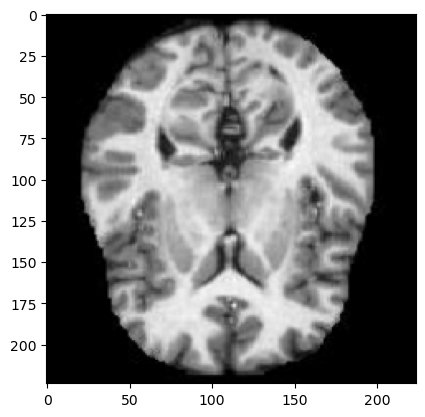

In [31]:
plt.imshow(X_train[1])

In [32]:
# Fit the model.

history = model.fit(
    X_train_Reshape1,y_smote,
    validation_split=0.2,
    epochs = 50,
    batch_size = 32
)

Epoch 1/50
256/256 [==============================] - 521s 2s/step - loss: 1.6138 - accuracy: 0.4486 - val_loss: 1.4704 - val_accuracy: 0.2842
Epoch 2/50
256/256 [==============================] - 499s 2s/step - loss: 1.1291 - accuracy: 0.5560 - val_loss: 1.1248 - val_accuracy: 0.6270
Epoch 3/50
256/256 [==============================] - 573s 2s/step - loss: 1.0184 - accuracy: 0.6014 - val_loss: 1.2121 - val_accuracy: 0.6460
Epoch 4/50
256/256 [==============================] - 680s 3s/step - loss: 1.0003 - accuracy: 0.6155 - val_loss: 1.4857 - val_accuracy: 0.5625
Epoch 5/50
256/256 [==============================] - 667s 3s/step - loss: 0.9346 - accuracy: 0.6433 - val_loss: 0.9173 - val_accuracy: 0.6279
Epoch 6/50
256/256 [==============================] - 538s 2s/step - loss: 0.9232 - accuracy: 0.6570 - val_loss: 0.7488 - val_accuracy: 0.7339
Epoch 7/50
256/256 [==============================] - 527s 2s/step - loss: 0.9309 - accuracy: 0.6619 - val_loss: 0.8455 - val_accuracy: 0.6685

In [33]:
y_smote.shape

(10240, 4)

In [34]:
# model.save('C:\\Users\\eesha\\Desktop\\Alz Detection\\archive (1)\\Alz_classifier2\\SavedModel2.h5')

In [53]:
img, label = next(test_set)
X_test = list(img)
y_test = list(label)

for i in tqdm(range(int(len(test_set))-1)): #1st batch is already fetched before the for loop.
  img, label = next(test_set)
  X_test += list(img)
  y_test +=  list(label)

X_test = np.array(X_test)
y_test = np.array(y_test)

print(X_test.shape, y_test.shape)

100%|██████████| 39/39 [00:13<00:00,  2.85it/s]


(1279, 224, 224, 3) (1279, 4)


In [54]:
X_test.shape

(1279, 224, 224, 3)

In [55]:
print(X_test.shape, y_test.shape)

(1279, 224, 224, 3) (1279, 4)


In [56]:
X_test_Reshape = X_test.reshape(1279, 224*224*3)

In [57]:
X_test_Reshape.shape

(1279, 150528)

In [58]:
sm = SMOTE(k_neighbors=10)
X_smote, y_test_smote = sm.fit_resample(X_test_Reshape, y_test)

In [59]:
X_smote.shape

(2560, 150528)

In [67]:
np.argmax(y_test_smote,axis=1).shape

(2560,)

In [68]:
np.unique(np.argmax(y_test_smote,axis=1), return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([640, 640, 640, 640], dtype=int64))

In [62]:
X_test_Reshape1 = np.reshape(X_smote, (2560,224,224,3))

In [63]:
X_test_Reshape1.shape

(2560, 224, 224, 3)

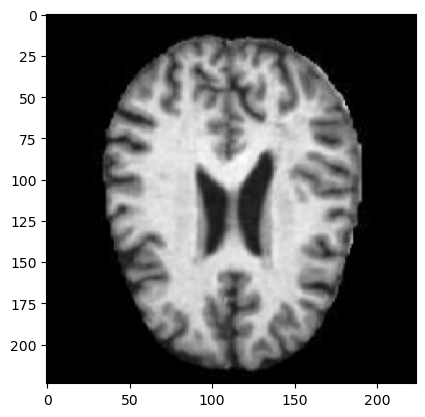

In [64]:
from matplotlib import pyplot as plt
plt.imshow(X_test_Reshape1[1])

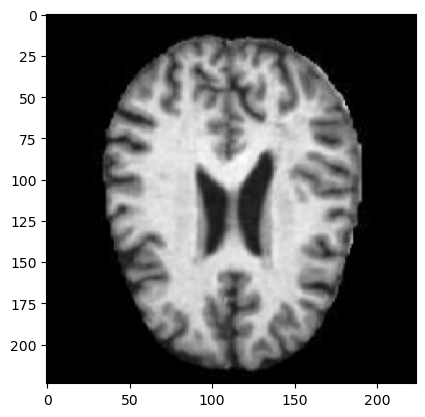

In [65]:
plt.imshow(X_test[1])

In [48]:
history.history

{'loss': [1.6138486862182617,
  1.1291261911392212,
  1.0184224843978882,
  1.0003082752227783,
  0.9345752596855164,
  0.9231840968132019,
  0.9308815002441406,
  0.835784912109375,
  0.7828494906425476,
  0.7289614081382751,
  0.7887800335884094,
  0.7861912250518799,
  0.8954408168792725,
  0.7656634449958801,
  0.7486574649810791,
  0.7843059301376343,
  0.5976084470748901,
  0.6454397439956665,
  0.7663962841033936,
  0.5906871557235718,
  0.58260577917099,
  0.5893382430076599,
  0.7387397885322571,
  0.5967711210250854,
  0.7012180685997009,
  0.5608862638473511,
  0.6297149658203125,
  0.7835066318511963,
  0.6655129194259644,
  0.6880766153335571,
  0.6141448020935059,
  0.521155059337616,
  0.49020621180534363,
  0.684693455696106,
  0.6064661741256714,
  0.49908074736595154,
  0.5215559601783752,
  0.6784343719482422,
  0.547731876373291,
  0.4913075268268585,
  0.5334188342094421,
  0.5335444808006287,
  0.5305134654045105,
  0.4693756401538849,
  0.4866494834423065,
  0.54

In [69]:
results = model.evaluate(X_test_Reshape1, y_test_smote)

80/80 [==============================] - 109s 1s/step - loss: 2.8369 - accuracy: 0.3711


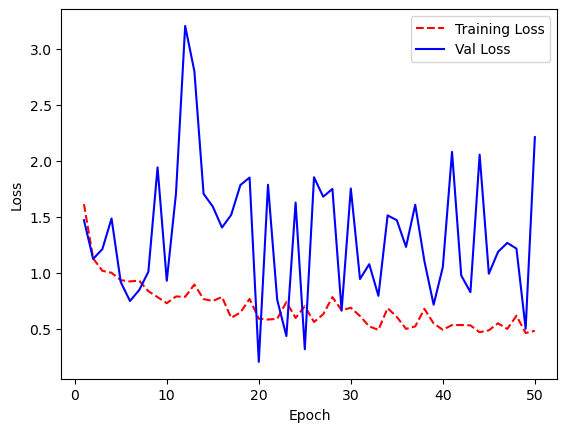

In [73]:
# Get training and test loss histories
training_loss = history.history['loss']
testing_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, testing_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

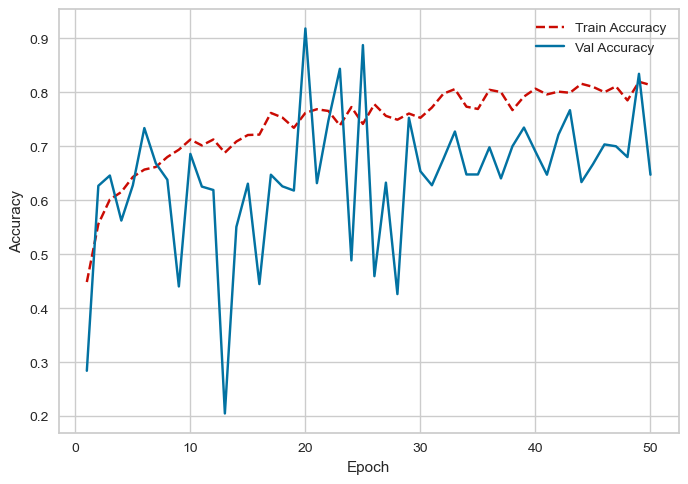

In [84]:
# Testing and Validation Acc for Smote Dataset
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Train Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show();

In [87]:
y_pred = model.predict(X_test_Reshape1)

80/80 [==============================] - 120s 1s/step


In [98]:
# Calculating ROC-AUC
from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Learn to predict each class against the other

n_classes = 4 # number of class

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_smote[:, i], y_pred[:, i], )
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_smote.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

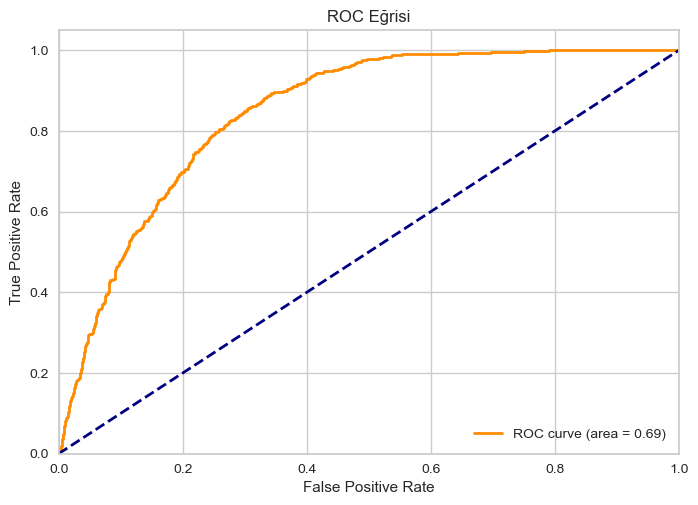

In [101]:
plt.figure()
lw = 2 # line_width
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[3]) # Drawing Curve according to 3. class 
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()

C:\Users\eesha\AppData\Local\Temp\ipykernel_340\3010557118.py:11: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


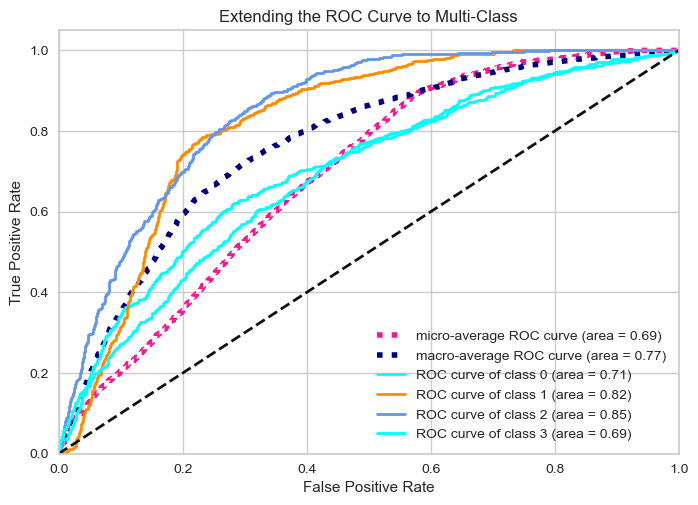

In [102]:
# Process of plotting roc-auc curve belonging to all classes.

from itertools import cycle
roc_auc_scores = []
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    roc_auc_scores.append(roc_auc[i])

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extending the ROC Curve to Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [107]:
from tensorflow import keras

def build_model(hp):
    model = Model(inputs = resnet.input, outputs = prediction)
    model.compile (
        loss = 'categorical_crossentropy',
        optimizer = keras.optimizers.Adam(
            hp.Choice('learning_rate',
                     values = [1e-2, 1e-4])),
        metrics = ['accuracy']
        )
    return model
    

In [108]:
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    build_model,
    objective = 'val_accuracy',
    max_trials =5,
    executions_per_trial=3)

In [109]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.0001], 'ordered': True}


In [ ]:
tuner.search(X_test_Reshape1, y_smote,
            epochs=5,
            validation_data=(X_test_Reshape1, y_test_smote))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
0.0001            |?                 |learning_rate

Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 2.0193 - accuracy: 0.4676